<div style='border:solid green 5px; padding: 40px'>

# <font color='darkgreen'>**Проект по разработке ML-модели для сопоставления текстов музыкальных произведений и для поиска каверов по их текстам для Яндекс Музыка**</font>
    
</div>

_**Цель проекта: для компании Яндекс Музыка разработать ML-модель для сопоставления текстов музыкальных произведений и для поиска каверов (вариации обработки оригинала с элементами новой аранжировки) по их текстам.**_

Обнаружение треков каверов - важная продуктовая задача, которая может значительно улучшить качество рекомендаций музыкального сервиса и повысить счастье пользователей. Если сервис может с высокой точностью классифицировать каверы и связывать их между собой, то можно предложить пользователю новые возможности для управления потоком треков. Например: по желанию пользователя можно полностью исключить каверы из рекомендаций; показать все каверы на любимый трек пользователя; контролировать долю каверов в ленте пользователя.

В ходе проекта нужно разработать решение, которое:
 - может классифицировать треки по признаку кавер-некавер;
 - связывать (группировать) каверы и исходный трек;
 - находить исходный трек в цепочке каверов.

В идеале решение должно выполнять все три функции. Но для заказчика интересны также решения хотя бы одной из задач.

### Разметка каверов

### Файл covers.json содержит разметку каверов, сделанную редакторами сервиса:

- track_id - уникальный идентификатор трека;
- track_remake_type - метка, присвоенная редакторами. Может принимать значения ORIGINAL и COVER;
- original_track_id - уникальный идентификатор исходного трека.

### Метаинформация

- track_id - уникальный идентификатор трека;
- dttm - первая дата появления информации о треке;
- title - название трека;
- language - язык исполнения;
- isrc - международный уникальный идентификатор трека;
- genres - жанры;
- duration - длительность трека;

### Текст песен

- track_id - уникальный идентификатор трека;
- lyricId - уникальный идентификатор текста;
- text - текст трека.

## Загрузка и исследовательский анализ данных (Exploratory data analysis)

In [1]:
!pip install -U sentence-transformers -q
!pip install ipywidgets -q
!pip install catboost -q
!pip install shap -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 68.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 70.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 90.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 70.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 8.5 MB/s eta 0:00:00


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sentence_transformers import SentenceTransformer
from sentence_transformers import util
from tqdm import notebook

from catboost import CatBoostClassifier, Pool, metrics, cv
from sklearn.metrics import accuracy_score, classification_report
from sklearn.dummy import DummyClassifier

import shap

In [3]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


### meta

In [4]:
meta = pd.read_json('/gdrive/MyDrive/Colab Notebooks/meta.json', lines=True)

In [5]:
meta['track_id'].duplicated().sum()

0

In [6]:
meta = meta.set_index('track_id')
meta['dttm'] = pd.to_datetime(meta['dttm'], unit='ms')

In [7]:
meta.head()

,dttm,title,language,isrc,genres,duration
track_id,,,,,,
c3b9d6a354ca008aa4518329aaa21380,2021-12-16 21:00:00,Happy New Year,EN,RUB422103970,[DANCE],161120.0
c57e3d13bbbf5322584a7e92e6f1f7ff,2021-11-24 14:00:33,Bad Habits,EN,QZN882178276,[ELECTRONICS],362260.0
955f2aafe8717908c140bf122ba4172d,2021-11-24 15:37:03,Por Esa Loca Vanidad,None,QZNJZ2122549,"[FOLK, LATINFOLK]",260000.0
fae5a077c9956045955dde02143bd8ff,2021-11-24 15:37:03,Mil Lagrimas,None,QZNJZ2166033,"[FOLK, LATINFOLK]",190000.0
6bede082154d34fc18d9a6744bc95bf5,2021-11-24 15:37:03,Sexo Humo y Alcohol,None,QZNJZ2122551,"[FOLK, LATINFOLK]",203000.0


In [8]:
meta.info()

<class 'pandas.core.frame.DataFrame'>
Index: 71769 entries, c3b9d6a354ca008aa4518329aaa21380 to 5731fc0a34c663a0c0082c712df15266
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   dttm      71768 non-null  datetime64[ns]
 1   title     71768 non-null  object        
 2   language  21969 non-null  object        
 3   isrc      71455 non-null  object        
 4   genres    71768 non-null  object        
 5   duration  71768 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(4)
memory usage: 3.8+ MB


In [9]:
meta = meta.drop([None])

In [10]:
meta['isrc'].duplicated().sum()

484

Всего 71283 уникальных международных идентификаторов трека. В Википедии написано, что различные записи, редакции и ремиксы одной и той же песни будут иметь различные коды isrc. Следовательно, имеющиеся повторы isrc говорят об аномалии. Треки с одним isrc имеют разные даты dttm (дату релиза или дату загрузки в базу?), разную длительность, для некоторых не указан язык исполнения. На стадии предобработки данных для baseline модели возможно будет лучше удалить дубли, оставив один из них с наиболее полной информацией.

In [11]:
meta['genres'].value_counts().head(10)

[FOLK, LATINFOLK]    18391
[POP]                13157
[ROCK, ALLROCK]       5898
[ALTERNATIVE]         3570
[FOLK]                2645
[]                    2352
[ELECTRONICS]         2231
[SOUNDTRACK]          2181
[DANCE]               2166
[SPIRITUAL]           1552
Name: genres, dtype: int64

In [12]:
meta['language'] = meta['language'].fillna('unknown')

In [13]:
meta['genres'] = meta['genres'].apply(lambda x: ', '.join(sorted(x)))

In [14]:
meta.loc[meta['genres'] == '', 'genres'] = 'unknown'

Text(0, 0.5, 'Frequency')

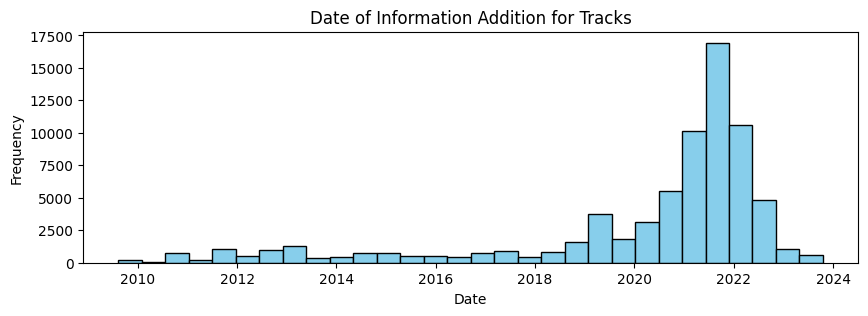

In [15]:
plt.figure(figsize=(10, 3))

plt.hist(meta['dttm'], bins=30, color='skyblue', edgecolor='black')

plt.title('Date of Information Addition for Tracks')
plt.xlabel('Date')
plt.ylabel('Frequency')

Основная масса треков либо имеет год выхода либо подгружена в базу с 2020 по 2023 год.

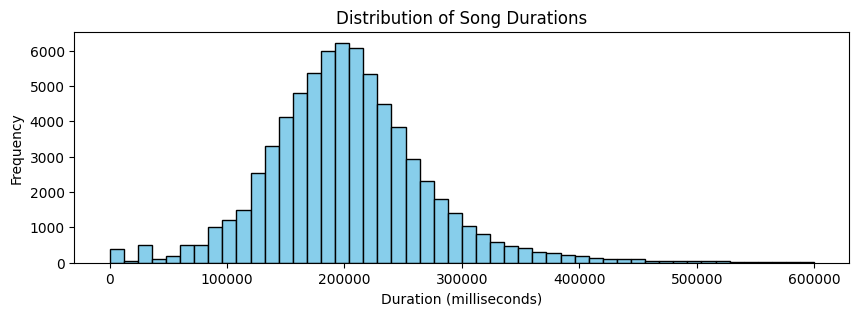

In [16]:
plt.figure(figsize=(10, 3))
plt.hist(meta['duration'], bins=50, range=(0, 600000), color='skyblue', edgecolor='black')
plt.title('Distribution of Song Durations')
plt.xlabel('Duration (milliseconds)')
plt.ylabel('Frequency')
plt.show()

посмотрим на распределение языков исполнения

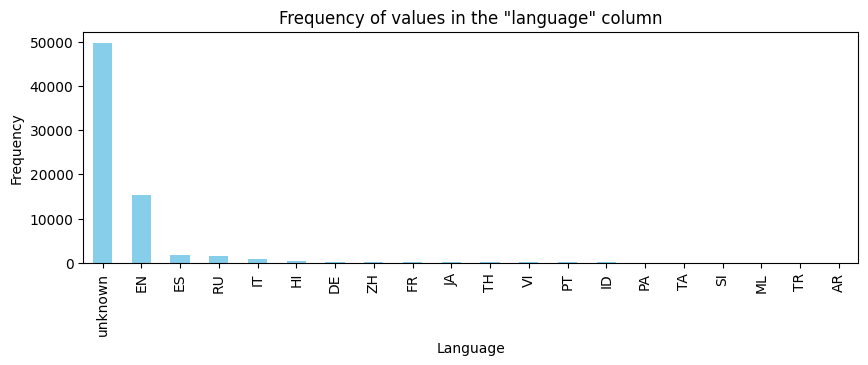

In [17]:
language_counts = meta['language'].value_counts().head(20)
plt.figure(figsize=(10, 3))
language_counts.plot(kind='bar', color='skyblue')
plt.title('Frequency of values in the "language" column')
plt.xlabel('Language')
plt.ylabel('Frequency')
plt.show()

уникальные языки исполнения

In [69]:
meta['language'].unique()

array(['EN', 'unknown', 'ES', 'HI', 'DE', 'RU', 'TR', 'HU', 'TH', 'PL',
       'FR', 'NY', 'AF', 'AS', 'UZ', 'HT', 'EL', 'AZ', 'IT', 'PA', 'PT',
       'TA', 'JA', 'ML', 'VI', 'ID', 'LA', 'CS', 'SI', 'UK', 'OR', 'HR',
       'AR', 'KK', 'FI', 'IE', 'ZH', 'AB', 'KN', 'FA', 'BN', 'TL', 'SK',
       'KS', 'SV', 'RO', 'TN', 'KO', 'MS', 'BM', 'HY', 'TW', 'MY', 'CA',
       'NL', 'ET', 'TE', 'MN', 'HE', 'SQ', 'IG', 'MR', 'BE', 'LT', 'UR',
       'IA', 'GN', 'SW', 'NO', 'GU', 'KY', 'KU', 'IS', 'TG', 'SR', 'DA',
       'LO', 'LV', 'SE', 'WO', 'SA', 'YO', 'ST', 'HA', 'AV', 'IU'],
      dtype=object)

Всего представлены 85 языков исполнения. Самый распространенный - английский - на нем исполняется подавляющее число композиций (более 15 000). Далее со значительным отставанием (менее 2 000) следуют испанский и русский язык. На остальных языках исполняется менее, чем по 1000 треков. В этом признаке содержится около 70% пропусков. Необходимо либо восполнять данные, либо возможно отказываться от этого признака в пользу новых из других источников.

посмотрим какие жанры присущи трекам

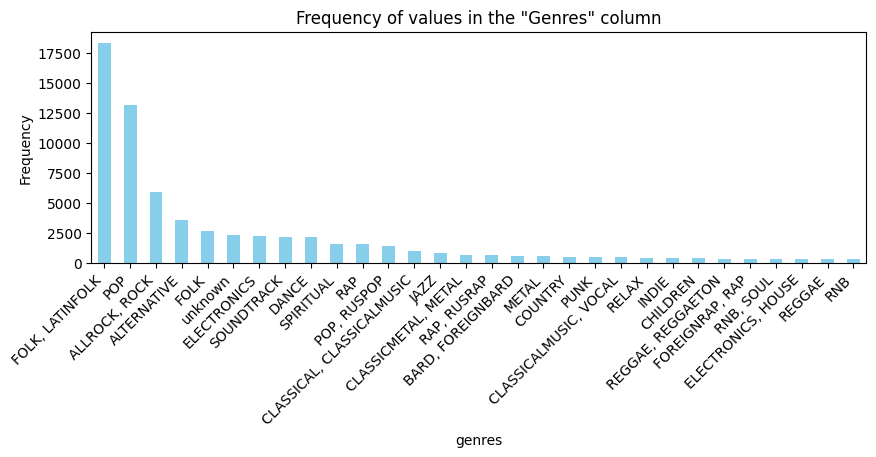

In [71]:
genre_counts = meta['genres'].value_counts().head(30)
plt.figure(figsize=(10, 3))
genre_counts.plot(kind='bar', color='skyblue')
plt.title('Frequency of values in the "Genres" column')
plt.xlabel('genres')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.xticks(ha='right')
plt.show()

## covers

In [19]:
covers = pd.read_json('/gdrive/MyDrive/Colab Notebooks/covers.json', lines=True)

In [20]:
covers['track_id'].duplicated().sum()

0

In [21]:
covers = covers.set_index('track_id')

In [22]:
covers.head()

,original_track_id,track_remake_type
track_id,,
eeb69a3cb92300456b6a5f4162093851,eeb69a3cb92300456b6a5f4162093851,ORIGINAL
fe7ee8fc1959cc7214fa21c4840dff0a,fe7ee8fc1959cc7214fa21c4840dff0a,ORIGINAL
cd89fef7ffdd490db800357f47722b20,cd89fef7ffdd490db800357f47722b20,ORIGINAL
995665640dc319973d3173a74a03860c,995665640dc319973d3173a74a03860c,ORIGINAL
d6288499d0083cc34e60a077b7c4b3e1,None,COVER


In [23]:
covers.info();

<class 'pandas.core.frame.DataFrame'>
Index: 71597 entries, eeb69a3cb92300456b6a5f4162093851 to 7b0f6ff24137be50cf5ea5f82d789448
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   original_track_id  4821 non-null   object
 1   track_remake_type  71597 non-null  object
dtypes: object(2)
memory usage: 1.6+ MB


In [24]:
covers['original_track_id'] = covers['original_track_id'].fillna('unknown')

In [25]:
covers['track_remake_type'].value_counts()

COVER       67304
ORIGINAL     4293
Name: track_remake_type, dtype: int64

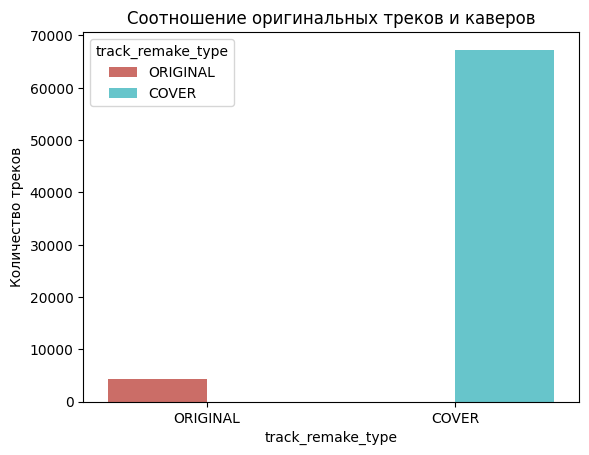

In [27]:
countplot = sns.countplot(data=covers, x='track_remake_type', palette='hls', hue = 'track_remake_type')
countplot.set_title('Соотношение оригинальных треков и каверов')
countplot.set_ylabel('Количество треков')
plt.show()

посмотрим распределение уникальных ID оригинальных треков

In [28]:
covers['original_track_id'].value_counts().to_frame().head(10)

,original_track_id
unknown,66776
f3e5e9db509f9b6f6d93b9c38e4e1324,38
17a163f6ab3de102b49599f5577866fc,32
deb9b9598176a0bab1212d430b10bd04,31
53a04991308c2cc9179fdd401fea83a3,30
9050384cce6c221c39d6e25d02561612,25
eeb69a3cb92300456b6a5f4162093851,25
8e0235cf2a39eacc4c78885ca7dd4de3,24
ad1b9fe17c16ab73b2a52920fdb1a220,19
cfcd208495d565ef66e7dff9f98764da,17


In [29]:
covers[covers['track_remake_type'] == 'ORIGINAL'].duplicated().sum()

0

Кол-во каверов с имеющимися 'original_track_id':

In [31]:
covers.loc[(covers['track_remake_type'] == 'COVER') & (covers['original_track_id'] != 'unknown'), 'original_track_id'].count()

528

### lyrics

In [56]:
lyrics = pd.read_json('/gdrive/MyDrive/Colab Notebooks/lyrics.json', lines=True)

In [57]:
lyrics.head()

,lyricId,text,track_id
0,a951f9504e89759e9d23039b7b17ec14,"Живу сейчас обломами, обломками не той любви\n...",1c4b1230f937e4c548ff732523214dcd
1,0c749bc3f01eb8e6cf986fa14ccfc585,Tell me your fable\nA fable\nTell me your fabl...,0faea89b0d7d6235b5b74def72511bd8
2,e2c8830fbc86e5964478243099eec23a,You're ashamed about all your fears and doubts...,9c6dc41d5ccd9968d07f055da5d8f741
3,e2c8830fbc86e5964478243099eec23a,You're ashamed about all your fears and doubts...,bfd04a73e9cffdf0e282c92219a86ea1
4,7624653ca8522ba93470843c74961b7d,"You showed him all the best of you,\nBut I'm a...",8d70930d09cd239c948408d1317d8659


Дубликаты по столбцам:

In [58]:
lyrics['track_id'].duplicated().sum()

1137

In [59]:
lyrics['text'].duplicated().sum()

770

In [60]:
lyrics['lyricId'].duplicated().sum()

499

In [61]:
lyrics[lyrics['track_id'].duplicated()].sort_values('track_id')

,lyricId,text,track_id
10681,039236cf5355b4a81a7d5e689dbbf00a,Hearts go astray\nLeaving hurt when they go\nI...,0021519c8533f1116591948bbb349aef
10686,0abe3bb343894590423064dee2d2a114,Hearts go astray\nLeaving hurt when they go\nI...,0021519c8533f1116591948bbb349aef
11306,1682f991cfa94d1440bef2aa417edec7,"If I stay with you, if I'm choosing wrong\nI d...",0102189356af15ad0be804eddd9bc24a
9220,6e3781576e60cfbee15f65d626ac130a,"If I stay with you, if I'm choosing wrong\nI d...",0102189356af15ad0be804eddd9bc24a
8330,52d3570b1f1e50113f10cdd65869614e,Well sometimes I go out by myself\nAnd I look ...,02db8e8e8d3c08f3a57cc6db3876f942
...,...,...,...
8880,b48c26ba7186a8de9de9f3121a783da4,I got lost in the wilderness\nI thought I was ...,fd93fa564461b42fea969d6cc1d16c18
7556,6ba951bfe34b90ab611f63c67caa708f,This night is cold in the kingdom\nI can feel ...,ff032309afbd44985497077e1f041e97
11229,b2bd7e1c3e5b8987b0a7df143a2c3c0f,"I cover the waterfront,\nI'm watching the sea,...",ff54e3bcd7ef7aeb41c91f9abeac9c68
8881,d9107cc98fb6dc91853ea69ac98f1d58,Don't go tonight\nStay here one more time\nRem...,ff77df3ccccd54654ea4b2209dd6e38c


In [62]:
lyrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11414 entries, 0 to 11413
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   lyricId   11414 non-null  object
 1   text      11414 non-null  object
 2   track_id  11414 non-null  object
dtypes: object(3)
memory usage: 267.6+ KB


частота уникальных значений track_id

In [64]:
lyrics['track_id'].value_counts().to_frame().head()

,track_id
b891000882f4a612190142861b5c038b,24
adc126c946551da4e1784e716b77992e,17
f0f429d03fdd19f08ff60e889e32aae2,16
951edd96627f47b783716a54d2368d7b,12
ca1c4cbc9b1cb3197ed5e52df9caf573,12


посмотрим подробнее на самый часто упоминающийся track_id  = 'b891000882f4a612190142861b5c038b'

In [66]:
lyrics[lyrics['track_id'] == 'b891000882f4a612190142861b5c038b']

,lyricId,text,track_id
1800,6510c50bec7a64a02a3a198793d81f2b,The night I laid my eyes on you\nFelt everythi...,b891000882f4a612190142861b5c038b
1814,5de2a48ffe755a226704bb6db2f1b743,The night I laid my eyes on you\nFelt everythi...,b891000882f4a612190142861b5c038b
3360,89d690b2da9a4827cfd9f1fa088ec207,"La, la, la, la, la, la, la, la, la, la, la, la...",b891000882f4a612190142861b5c038b
5304,1a6450a439b4d385b40f3077d308e01a,The night I laid my eyes on you\nFelt everythi...,b891000882f4a612190142861b5c038b
6007,3aa4b1682c24f8ce982245856da157d6,The night I laid my eyes on you\nFelt everythi...,b891000882f4a612190142861b5c038b
6175,5fdc9a316a05bca8a5d6b1d5da453659,The night I laid my eyes on you\nFelt everythi...,b891000882f4a612190142861b5c038b
6535,66183e0ff8df93904f9f67b63e6980d9,The night I laid my eyes on you\nFelt everythi...,b891000882f4a612190142861b5c038b
7595,11ba6102483116158e814fcc7bbdc55e,The night I laid my eyes on you\nFelt everythi...,b891000882f4a612190142861b5c038b
7601,504c9590913941d22dd49124f63d4d5e,La lalala lala lalala lala\nLa lalala lala lal...,b891000882f4a612190142861b5c038b
7602,913ae25eda32c1b63d180562d65fade2,La lalala lala lalala lala\nLa lalala lala lal...,b891000882f4a612190142861b5c038b


посмотрим, например, на текст песни с индексом 7595

In [67]:
lyrics['text'][7595]

"The night I laid my eyes on you\nFelt everything around me move\nGot nervous when you looked my way\nBut you knew all the words to say\n\nThen your love slowly moved right in\nAll this time oh my love where've you been\n\nMi amore don't you know\nMy love I want you so\nSugar you make my soul complete\nRapture tastes so sweet\n\nI'm mesmerized in every way\nYou keep me in a state of daze\nYou're kisses make my skin feel weak\nI'm always melting in your heat\n\nThen I soar like a bird in the wind\nOh I glide as I'm flying through heaven\n\nMi amore don't you know\nMy love I want you so\nSugar you make my soul complete\nRapture tastes so sweet\n\nSince we connect behind closed doors\nSpark this fire even more\nNo telling where we will be next\nSurrender to your rapture arrest\nLay your head, let the slumber float\nCan't resist, that's why words were wrote\n\nMi amore don't you know\nMy love I want you so\nSugar you make my soul complete\nRapture tastes so sweet"

и на текст песни с индексом 7601

In [68]:
lyrics['text'][7601]

"La lalala lala lalala lala\nLa lalala lala lalala lala\n\nThe night I laid my eyes on you,\nFelt everything around me move\nGot nervous when you looked my way\nBut you knew all the words to say.\n\nThen your love slowly moved right in\nAll this time all my love where you been.\n\nMe, amore don't you know\nMy love I want you so\nSugar you make my soul complete\nRapture tastes so sweet.\n\nMesmerised in every way\nKeep me in a state of daze\nYour kisses make my skin feel weak\nAlways melting in your heat.\n\nThen I soar like a bird in the wind\nOh I glide as I'm flying through heaven.\n\nMe, amore don't you know\nMy love I want you so\nSugar you make my soul complete\nRapture tastes so sweet.\n\nMe, amore dont you know\nMy love I want you so\nSugar you make my soul complete\nRapture tastes so sweet\n\nLa lalala lala lalala lala\nLa lalala lala lalala lala\n\nMe, amore don't you know\nMy love I want you so\nSugar you make my soul complete\nRapture tastes so sweet.\n\nMe, amore don't you 

Во втором случае в начале песни добавлены слова la la la, а также они же периодически повторяются в течение всей песни. И таких отличий между текстами песен одного track_id довольно много. При этом все они имеют разный lyricId из-за разных комбинаций и количества la la la. В других треках тексты могут отличаться только знаками препинания. Заказчик объясняет это тем, что для каждого трека могло быть несколько источников текстов, а также ошибками (дублированием) при загрузке данных.

При обработке текстов некоторые слова, частицы, союзы, знаки препинания и пр.будут удалены, поэтому для одного уникального track_id можно взять любой текст (lyricId).

In [52]:
lyrics.drop_duplicates(subset=['track_id'], inplace=True)

In [53]:
lyrics = lyrics.set_index('track_id')

Дубликаты по обоим столбцам:

In [41]:
lyrics.duplicated().sum()

386

Дубликаты по совпадению первых 50 знаков по столбце 'text':

In [42]:
lyrics['text'].str[:50].duplicated().sum()

1355

In [43]:
lyrics['text'].str[:50].value_counts()

The world was on fire and no one could save me but      21
Sweet dreams are made of this\nWho am I to disagree     19
Kiss me hard before you go\nSummertime sadness\nI ju    13
When you were here before\nCouldn't look you in the     13
Another head hangs lowly\nChild is slowly taken\nAnd    12
                                                        ..
Тут качает ганджа в малиновой Ладе\nМутим темы, что      1
I've known some painted ladies\nThat sparkled in th      1
¿Cómo quieres ser mi amiga\nSi por ti daría la vida      1
I've been feeling kinda lonely\nMaybe I need someon      1
Этой ночью чьё-то сердце от любви горит\nВсё внутри      1
Name: text, Length: 8922, dtype: int64

## Объединенный датасет

In [ ]:
df = meta.join(covers, how='left')
df = df.join(lyrics, how='left')

In [ ]:
df.tail()

,dttm,title,language,isrc,genres,duration,original_track_id,track_remake_type,lyricId,text
track_id,,,,,,,,,,
4be93dea1715e54db86aaa7f7e9bfb10,2019-06-13 05:20:09,Chanceuse,FR,CAISO1800023,INDIE,212690.0,unknown,COVER,NaN,NaN
7cba0f30eaa8766d6c203eff2f3750a2,2019-06-13 13:34:03,Quiero Que Vuelvas,unknown,ES71G1738868,POP,237540.0,unknown,COVER,NaN,NaN
26b6aca1c6a02ad0e2a939164716657e,2019-06-13 17:50:02,Vacation,EN,USA2B1511447,ALTERNATIVE,215210.0,unknown,COVER,NaN,NaN
d904dda141238e6ad1b428bfbb21262d,2019-06-13 17:50:02,Dance Hall Days,EN,USA2B1511448,ALTERNATIVE,251010.0,unknown,COVER,NaN,NaN
5731fc0a34c663a0c0082c712df15266,2021-06-30 21:00:00,17,RU,FR59R1921791,"POP, RUSPOP",175640.0,5731fc0a34c663a0c0082c712df15266,ORIGINAL,00cdce64d0559ea65ec245d05735e2b0,Собери по осколкам моё разбитое сердце\nСбита ...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 71768 entries, c3b9d6a354ca008aa4518329aaa21380 to 5731fc0a34c663a0c0082c712df15266
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   dttm               71768 non-null  datetime64[ns]
 1   title              71768 non-null  object        
 2   language           71768 non-null  object        
 3   isrc               71455 non-null  object        
 4   genres             71768 non-null  object        
 5   duration           71768 non-null  float64       
 6   original_track_id  71597 non-null  object        
 7   track_remake_type  71597 non-null  object        
 8   lyricId            10277 non-null  object        
 9   text               10277 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(8)
memory usage: 8.0+ MB


In [ ]:
df[df['genres'].isna()]

,dttm,title,language,isrc,genres,duration,original_track_id,track_remake_type,lyricId,text
track_id,,,,,,,,,,


In [ ]:
df.describe(include='all')

<ipython-input-87-174ba9bf1a5c>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.describe(include='all')


,dttm,title,language,isrc,genres,duration,original_track_id,track_remake_type,lyricId,text
count,71768,71768,71768,71455,71768,7.176800e+04,71597,71597,10277,10277
unique,27726,45462,86,71283,232,NaN,4469,2,9891,9852
top,2013-03-11 20:00:00,Morena,unknown,USTCF1018560,"FOLK, LATINFOLK",NaN,unknown,COVER,6fe05ce48761f833737487cd7a499cd3,"A and X, El Orfanato\nDanza Kuduro\nLucenzo El..."
freq,839,81,49799,3,18391,NaN,66776,67304,9,9
first,2009-08-10 17:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2023-10-18 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,2.049187e+05,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,8.559854e+04,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,0.000000e+00,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,1.613700e+05,NaN,NaN,NaN,NaN


## Feature Preparation

Now let's separate features and label variable:

In [ ]:
df_del_isna_y = df[df['track_remake_type'].isna() == 0]

In [ ]:
df_del_isna_y.shape[0]

71597

In [ ]:
X = df_del_isna_y[['dttm', 'title', 'language', 'genres', 'duration', 'original_track_id']]
y = df_del_isna_y.track_remake_type

In [ ]:
X.dtypes

dttm                 datetime64[ns]
title                        object
language                     object
genres                       object
duration                    float64
original_track_id            object
dtype: object

In [ ]:
categorical_features_indices = np.where(X.dtypes == object)[0]
categorical_features_indices

array([1, 2, 3, 5])

## Data Splitting

Let's split the train data into training and validation sets.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_vt, y_train, y_vt = train_test_split(X, y, train_size=0.60, random_state=42)
X_test, X_validation, y_test, y_validation = train_test_split(X_vt, y_vt, train_size=0.50, random_state=42)

In [ ]:
print("Training Features:", X_train.shape)
print("\nTraining Target:", y_train.shape)
print("\nTesting Features:", X_test.shape)
print("\nTesting Target:", y_test.shape)

Training Features: (42958, 6)

Training Target: (42958,)

Testing Features: (14319, 6)

Testing Target: (14319,)


## CatBoost Basics

## Model Training

In [ ]:
model = CatBoostClassifier(
    custom_loss=[metrics.Accuracy()],
    random_seed=42,
    logging_level='Silent'
)

In [ ]:
%%time
model.fit(
    X_train, y_train,
    cat_features=categorical_features_indices,
    eval_set=(X_validation, y_validation)
);

CPU times: user 1min 42s, sys: 2.4 s, total: 1min 44s
Wall time: 1min 5s


## Model Applying

In [ ]:
y_pred = model.predict(X_test)
y_pred_probs = model.predict_proba(X_test)
print(y_pred[:10])
print(y_pred_probs[:10])

['COVER' 'COVER' 'COVER' 'COVER' 'COVER' 'COVER' 'COVER' 'COVER' 'COVER'
 'COVER']
[[9.99987515e-01 1.24849418e-05]
 [9.99989242e-01 1.07583711e-05]
 [9.99969847e-01 3.01531482e-05]
 [9.99504258e-01 4.95742076e-04]
 [9.99988014e-01 1.19857269e-05]
 [9.99997802e-01 2.19764321e-06]
 [9.99989823e-01 1.01772463e-05]
 [9.99963400e-01 3.65999353e-05]
 [9.99970748e-01 2.92522265e-05]
 [9.99947716e-01 5.22844706e-05]]


In [ ]:
report_cb = classification_report(y_test, y_pred, digits=4)
print(report_cb)

              precision    recall  f1-score   support

       COVER     0.9996    0.9975    0.9985     13459
    ORIGINAL     0.9618    0.9942    0.9777       860

    accuracy                         0.9973     14319
   macro avg     0.9807    0.9958    0.9881     14319
weighted avg     0.9974    0.9973    0.9973     14319



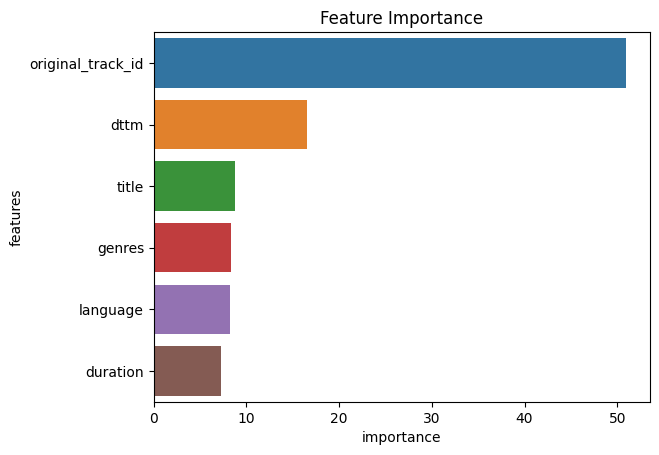

In [ ]:
feat_imp = pd.DataFrame()
feat_imp['importance'] = model.get_feature_importance()
feat_imp['features'] = X_train.columns
feat_imp.sort_values(by = 'importance', inplace = True, ascending = False)

sns.barplot(y = feat_imp['features'], x = feat_imp['importance'])
plt.title("Feature Importance")
plt.show()

### DummyClassifier

Создадим дамми-классификатора, который всегда предсказывает наиболее частый класс

In [ ]:
dummy_classifier = DummyClassifier(strategy="most_frequent")

In [ ]:
dummy_classifier.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

In [ ]:
y_pred_dummy = dummy_classifier.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred_dummy)
print(f'Accuracy of Dummy Classifier: {accuracy:.2f}')

Accuracy of Dummy Classifier: 0.94


In [ ]:
report_dummy = classification_report(y_test, y_pred_dummy, digits=3)
print(report_dummy)

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


              precision    recall  f1-score   support

       COVER      0.940     1.000     0.969     13459
    ORIGINAL      0.000     0.000     0.000       860

    accuracy                          0.940     14319
   macro avg      0.470     0.500     0.485     14319
weighted avg      0.883     0.940     0.911     14319



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


## LaBSE

В этом хакатоне вам предлагается разработать решение, которое:

1. может классифицировать треки по признаку кавер-некавер.  



- связывать (группировать) каверы и исходный трек;
- находит исходный трек в цепочке каверов.



Как работает модель SentenceTransformer('LaBSE'):

Подается текст в модель.  
Модель автоматически токенизирует текст, добавляет специальные токены [CLS] и [SEP], и преобразует текст в числовые токены.  
Модель кодирует текст с учетом его контекста и внутренних представлений BERT.
Векторное представление предложения извлекается из внутренних скрытых состояний модели.  
Если  на вход подаются тексты разной длины, то модель автоматически обработает их и создаст векторные представления, даже если длины текстов различаются.

In [ ]:
file_path = '/gdrive/MyDrive/Colab Notebooks/'

In [ ]:
# загрузить сохраненный массив эмбендингов из файла
embeddings_text = np.load(f'{file_path}embeddings_text.npy')
embeddings_title = np.load(f'{file_path}embeddings_title.npy')

In [ ]:
model = SentenceTransformer('sentence-transformers/LaBSE')

In [ ]:
non_empty_text_df = df[df['text'].notna()]

In [ ]:
df_text = non_empty_text_df['text']

In [ ]:
df_title = non_empty_text_df['title']

In [ ]:
def labse_convert(input_array, batch_size):
  embeddings = []
  for i in notebook.tqdm(range(input_array.shape[0] // batch_size)):
    batch = input_array[batch_size*i:batch_size*(i+1)]
    batch_embeddings = model.encode(batch)
    if len(embeddings) == 0:
      embeddings = batch_embeddings
    else:
      embeddings = np.concatenate((embeddings, batch_embeddings))
  return embeddings

In [ ]:
len(df_title)

10277

Создаем эмбендинги текстов треков

In [ ]:
embeddings_text = labse_convert(df_text, batch_size = 1)

  0%|          | 0/10277 [00:00<?, ?it/s]

Создаем эмбендинги названий треков

In [ ]:
embeddings_title = labse_convert(df_title, batch_size = 1)

  0%|          | 0/10277 [00:00<?, ?it/s]

In [ ]:
len(embeddings_title)

10277

Сохранение эмбендингов в файл

In [ ]:
#np.save(f'{file_path}embeddings_text', embeddings_text)

In [ ]:
#np.save(f'{file_path}embeddings_title', embeddings_title)

util.pytorch_cos_sim - это функция из библиотеки sentence_transformers, которая используется для вычисления косинусного сходства между векторами.

In [ ]:
row_index = df_text.index.get_loc('c3b9d6a354ca008aa4518329aaa21380')
row_index

0

In [ ]:
similarities = util.pytorch_cos_sim(embeddings_text[row_index],
                                    np.delete(embeddings_text, row_index, axis=0))[0]

Ранжируем тексты по схожести (чем ближе к 1, тем более похожи)

In [ ]:
sorted_indices = np.argsort(similarities.tolist())[-5:]
sorted_indices = sorted_indices[::-1]

In [ ]:
df_text_without_row = df_text.drop(df_text.index[row_index])

Установим пороговое значение разделения кавер / не кавер

In [ ]:
threshold_cover = 0.9

Вывод ранжированных текстов

In [ ]:
print("Ранжированные тексты:")
for i, idx in enumerate(sorted_indices):
    if similarities[idx] > threshold_cover:
        print(f"{i + 1}: {df_text_without_row.str[:80].tolist()[idx]} (Схожесть: {similarities[idx]:.4f})")

Ранжированные тексты:
1: No more champagne
And the fireworks are through
Here we are, me and you
Feeling  (Схожесть: 0.9780)


In [ ]:
substring = 'No more champagne\nAnd the fireworks are through'
filtered_df = df[df['text'].fillna('').str.contains(substring, case=False)]
filtered_df

,dttm,title,language,isrc,genres,duration,original_track_id,track_remake_type,lyricId,text
track_id,,,,,,,,,,
c3b9d6a354ca008aa4518329aaa21380,2021-12-16 21:00:00,Happy New Year,EN,RUB422103970,DANCE,161120.0,unknown,COVER,36777cce0740d1e3d37a5a221c71d859,No more champagne\nAnd the fireworks are throu...
804589c2558377b846122344fdc54a72,2010-01-06 21:00:00,Happy New Year,EN,SEAYD8001060,POP,263690.0,804589c2558377b846122344fdc54a72,ORIGINAL,f95d0aab2dfb9d328c2a853850a5ebc2,No more champagne\nAnd the fireworks are throu...
